In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
def random_horizontal_flip(frames, p=0.5):
        # frames: numpy array of shape (num_frames, H, W, C)
        if random.random() < p:
            # Use cv2.flip with flipCode=1 to flip horizontally
            frames = np.array([cv2.flip(frame, 1) for frame in frames])
        return frames

In [3]:
import os
import cv2
import numpy as np
import torch
import random
from torch.utils.data import Dataset

class RWF2K(Dataset):
    def __init__(self, video_dir, attack_classes, non_attack_classes, num_frames=16, resize=(64,64)):
        self.video_dir = video_dir
        self.attack_classes = [cls.lower() for cls in attack_classes]
        self.non_attack_classes = [cls.lower() for cls in non_attack_classes]
        self.num_frames = num_frames
        self.resize = resize
        self.video_list = []
        self.labels = []
        self._prepare_dataset()
        
    def _prepare_dataset(self):
        # Iterate over subdirectories (each corresponding to a class)
        for subdir in os.listdir(self.video_dir):
            subdir_path = os.path.join(self.video_dir, subdir)
            if os.path.isdir(subdir_path):
                folder_name = subdir.lower()
                # Only consider folders that belong to one of the two classes.
                if folder_name in self.attack_classes:
                    label = 1
                elif folder_name in self.non_attack_classes:
                    label = 0
                else:
                    continue  # Skip folders that are not of interest.
                for file in os.listdir(subdir_path):
                    if file.lower().endswith(('.avi', '.mp4', '.mov')):
                        self.video_list.append(os.path.join(subdir_path, file))
                        self.labels.append(label)
                        
    def __len__(self):
        return len(self.video_list)
    
    def _load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames_dict = {}
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            total_frames = self.num_frames
        # Uniformly sample frame indices.
        indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frame_id = 0
        ret = True
        while ret:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_id in indices:
                # Convert from BGR to RGB and resize.
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, self.resize)
                frames_dict[frame_id] = frame
            frame_id += 1
        cap.release()
        # Ensure we have self.num_frames by repeating the last available frame if needed.
        frames = []
        last_frame = None
        for idx in indices:
            if idx in frames_dict:
                frame = frames_dict[idx]
                last_frame = frame
            else:
                frame = last_frame if last_frame is not None else np.zeros((*self.resize, 3), dtype=np.uint8)
            frames.append(frame)
        frames = np.stack(frames)  # shape: (num_frames, H, W, C)
        return frames
    
    def __getitem__(self, idx):
        video_path = self.video_list[idx]
        label = self.labels[idx]
        frames = self._load_video(video_path)  # shape: (num_frames, H, W, C)
        
        # Apply random horizontal flip augmentation
        frames = random_horizontal_flip(frames, p=0.5)
        
        # Normalize pixel values to [0, 1]
        frames = frames.astype(np.float32) / 255.0
        # Rearrange dimensions to (C, T, H, W)
        frames = np.transpose(frames, (3, 0, 1, 2))
        video_tensor = torch.tensor(frames)
        return video_tensor, label

In [4]:
from torch.utils.data import DataLoader

# Define the root path of your dataset
DATASET_ROOT = r"C:\Users\Sravya Duvvuri\Documents\SRAVYA NEW\AMRITA\REGULAR SEM\SEMESTER 6\RESEARCH ELECTIVE\GIT_CLONED\data\rwf2k\RWF-2000"

train_dataset = RWF2K(
    video_dir=os.path.join(DATASET_ROOT, "train"),
    attack_classes=["fight"],
    non_attack_classes=["nonfight"],
    num_frames=16,
    resize=(112,112)
)

val_dataset = RWF2K(
    video_dir=os.path.join(DATASET_ROOT, "val"),
    attack_classes=["fight"],
    non_attack_classes=["nonfight"],
    num_frames=16,
    resize=(112,112)
)

# Create DataLoaders for training and validation
batch_size = 4  # Adjust based on your system's capacity

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))


Train set size: 1576
Validation set size: 400


In [5]:
from collections import Counter

def print_dataset_summary(dataset, dataset_name):
    counts = Counter(dataset.labels)
    # Ensure we always have both classes (default to 0 if not present)
    attack_count = counts.get(1, 0)
    non_attack_count = counts.get(0, 0)
    print(f"{dataset_name} summary:")
    print(f"  Attack (label 1): {attack_count} videos")
    print(f"  Non-Attack (label 0): {non_attack_count} videos")
    print(f"  Total videos: {len(dataset)}\n")

print_dataset_summary(train_dataset, "Train Dataset")
print_dataset_summary(val_dataset, "Validation Dataset")

Train Dataset summary:
  Attack (label 1): 776 videos
  Non-Attack (label 0): 800 videos
  Total videos: 1576

Validation Dataset summary:
  Attack (label 1): 200 videos
  Non-Attack (label 0): 200 videos
  Total videos: 400



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Enhanced3DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Enhanced3DCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv3d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)  # halves dimensions

        # Block 2
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        # Block 3
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2)

        #Block 4
        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(128)
        self.pool4 = nn.MaxPool3d(2)

        # Fully Connected layers with dropout
        self.adapt_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x): 
        # x: (B, C, T, H, W)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cpu")
model = Enhanced3DCNN(num_classes=2).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Start with 1e-3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Enhanced3DCNN(
  (conv1): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool3d(kerne

In [15]:
num_epochs = 70

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # shape: (B, C, T, H, W)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        () * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = train_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / total_test
    test_acc = 100 * correct_test / total_test
    scheduler.step(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% || "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save the model checkpoint at the end of this epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'train_acc': train_acc,
        'test_loss': avg_test_loss,
        'test_acc': test_acc
    }
    checkpoint_path = f"model_checkpoint_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")


Epoch [1/70] -> Train Loss: 0.1748, Train Acc: 60.47% || Test Loss: 0.8229, Test Acc: 64.50%
Checkpoint saved: model_checkpoint_epoch_1.pth
Epoch [2/70] -> Train Loss: 0.1553, Train Acc: 66.37% || Test Loss: 0.4842, Test Acc: 76.25%
Checkpoint saved: model_checkpoint_epoch_2.pth
Epoch [3/70] -> Train Loss: 0.1505, Train Acc: 68.72% || Test Loss: 0.4937, Test Acc: 78.25%
Checkpoint saved: model_checkpoint_epoch_3.pth
Epoch [4/70] -> Train Loss: 0.1549, Train Acc: 65.80% || Test Loss: 0.5285, Test Acc: 75.75%
Checkpoint saved: model_checkpoint_epoch_4.pth
Epoch [5/70] -> Train Loss: 0.1468, Train Acc: 70.81% || Test Loss: 0.4801, Test Acc: 74.50%
Checkpoint saved: model_checkpoint_epoch_5.pth
Epoch [6/70] -> Train Loss: 0.1472, Train Acc: 69.10% || Test Loss: 0.5153, Test Acc: 74.25%
Checkpoint saved: model_checkpoint_epoch_6.pth
Epoch [7/70] -> Train Loss: 0.1469, Train Acc: 70.62% || Test Loss: 0.4985, Test Acc: 74.75%
Checkpoint saved: model_checkpoint_epoch_7.pth
Epoch [8/70] -> Trai

In [14]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Set your device
device = torch.device("cpu")  # or torch.device("cuda") if using GPU

# Load the checkpoint from epoch 70
checkpoint_path = "model_checkpoint_epoch_70.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Collect predictions and ground truth labels from the entire validation dataset
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Use argmax over the class dimension
        _, preds = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calculate the metrics
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)
print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision: {:.2f}".format(prec))
print("Recall: {:.2f}".format(rec))
print("F1 Score: {:.2f}".format(f1))

Confusion Matrix:
[[165  35]
 [ 36 164]]
Accuracy: 82.25%
Precision: 0.82
Recall: 0.82
F1 Score: 0.82


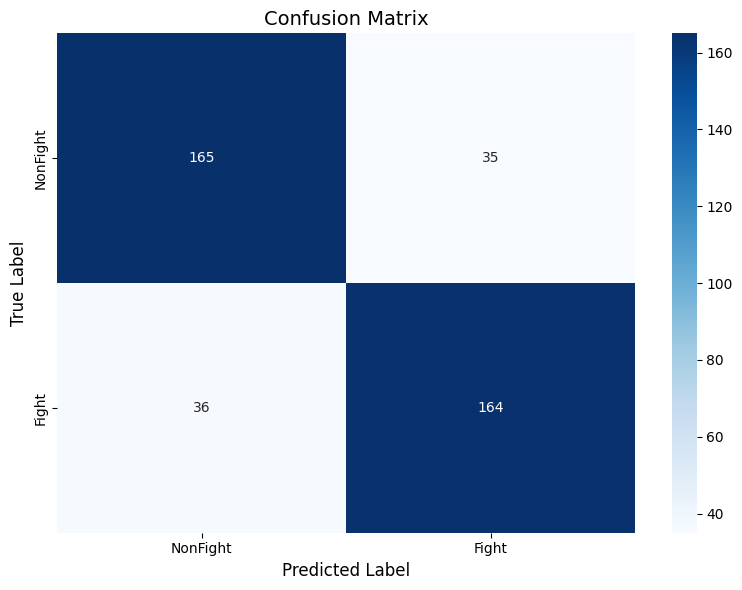

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['NonFight', 'Fight'], 
            yticklabels=['NonFight', 'Fight'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()